In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

file_path = 'datasets.csv'
data = pd.read_csv(file_path)

data.head()

,Customer_ID,Product_ID,Transaction_ID,Purchase_Frequency,Average_Order_Value,Most_Frequent_Category,Time_Between_Purchases,Region,Churn_Probability,Lifetime_Value,Launch_Date,Peak_Sales_Date,Season,Preferred_Purchase_Times,Retention_Strategy
0,CUST_9HOS83,PROD_IK97D1,TRANS_II1DZG,17,172.57,Electronics,45,South America,0.98,2993.56,2020-03-14,2023-09-11,Winter,Afternoon,Loyalty Program
1,CUST_AJU17N,PROD_UNN7KP,TRANS_9HJF7I,10,64.89,Clothing,6,South America,0.66,983.18,2022-10-15,2023-01-02,Spring,Afternoon,Discount
2,CUST_11XNYF,PROD_0XEW2W,TRANS_OT96OM,3,120.38,Sports,23,Asia,0.60,601.90,2021-11-30,2023-04-06,Winter,Evening,Loyalty Program
3,CUST_IGH8G3,PROD_3IIAJN,TRANS_45V00G,12,70.34,Clothing,5,North America,0.78,1082.15,2022-03-20,2023-03-23,Spring,Evening,Discount
4,CUST_OK6PUM,PROD_VMIWD2,TRANS_ZAK760,18,42.39,Electronics,10,North America,0.52,1467.35,2022-11-09,2023-10-28,Spring,Morning,Discount


In [84]:
# Memvisualisasikan statistika deskriptif dari dataset
statistik_dasar = data.describe()
print("Statistik Dasar:")
print(statistik_dasar)

Statistik Dasar:
       Purchase_Frequency  Average_Order_Value  Time_Between_Purchases  \
count        10000.000000         10000.000000            10000.000000   
mean             9.955700           110.006022               46.885300   
std              5.526209            52.096870               24.711746   
min              1.000000            20.010000                5.000000   
25%              5.000000            65.262500               25.000000   
50%             10.000000           109.930000               47.000000   
75%             15.000000           155.480000               68.000000   
max             19.000000           199.960000               89.000000   

       Churn_Probability  Lifetime_Value  
count       10000.000000    10000.000000  
mean            0.501552     5601.940770  
std             0.288289    15946.631117  
min             0.000000        0.000000  
25%             0.250000      840.955000  
50%             0.500000     1937.115000  
75%            

In [85]:
# Melihat jumlah nilai yang hilang (missing values)
print("\nNilai yang Hilang:")
print(data.isnull().sum())


Nilai yang Hilang:
Customer_ID                 0
Product_ID                  0
Transaction_ID              0
Purchase_Frequency          0
Average_Order_Value         0
Most_Frequent_Category      0
Time_Between_Purchases      0
Region                      0
Churn_Probability           0
Lifetime_Value              0
Launch_Date                 0
Peak_Sales_Date             0
Season                      0
Preferred_Purchase_Times    0
Retention_Strategy          0
dtype: int64


In [6]:
# Memilih fitur yang kami anggap relevan untuk mencari segmentasi dari customer
features = ['Purchase_Frequency', 'Average_Order_Value', 'Churn_Probability', 'Time_Between_Purchases', 'Lifetime_Value']

# Mengisi nilai kosong dengan nilai rata-rata pada setiap kolom/fitur yang dipilih
for feature in features:
    data[feature] = data[feature].fillna(data[feature].mean())

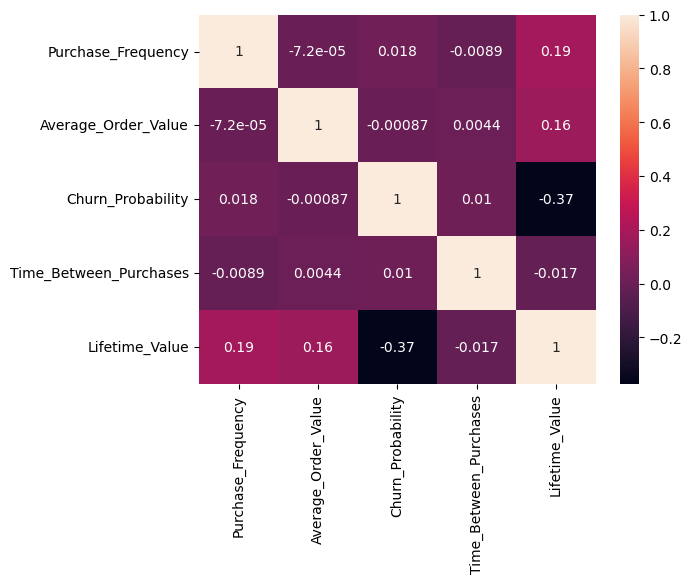

In [135]:
correlation = data[features].corr()
sns.heatmap(correlation, annot=True)
plt.show()

In [8]:
# Menggunakan metode IQR untuk mendeteksi outlier dan menghitung jumlahnya
for feature in features:  # Ganti dengan daftar fitur yang ingin diperiksa
    # Menghitung Q1 dan Q3
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Menentukan batas bawah dan atas
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Menandai outlier
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]

    # Menampilkan jumlah outlier
    print(f"Jumlah outlier untuk {feature}: {outliers.shape[0]}")


Jumlah outlier untuk Purchase_Frequency: 0
Jumlah outlier untuk Average_Order_Value: 0
Jumlah outlier untuk Churn_Probability: 0
Jumlah outlier untuk Time_Between_Purchases: 0
Jumlah outlier untuk Lifetime_Value: 1136


In [89]:
# Melakukan handling Outlier menggunakan metode IQR
for feature in features:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[feature] = data[feature].clip(lower_bound, upper_bound)

In [90]:
# Melakukan standarisasi data
scaler = StandardScaler()
segmented_data = scaler.fit_transform(data[features])

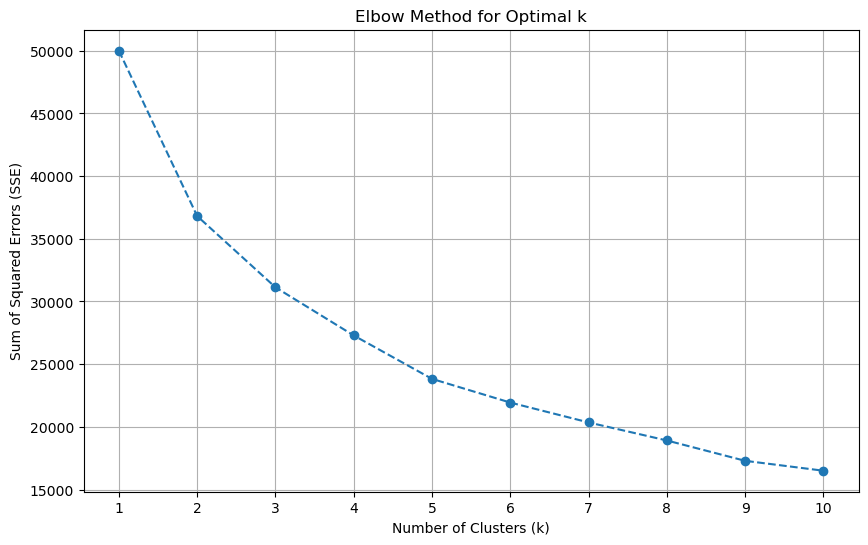

In [91]:
# Mencari nilai K yang optimal untuk K-Means menggunakan elbow method
sse = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(segmented_data)
    sse.append(kmeans.inertia_)

# Memvisualisasikan data
plt.figure(figsize=(10, 6))
plt.plot(k_values, sse, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [93]:
# Membuat loop untuk K=2 sampai K=5
silhouette_scores = []
for k in range(2, 6):
   kmeans = KMeans(n_clusters=k, random_state=42)
   labels = kmeans.fit_predict(segmented_data)
   score = silhouette_score(segmented_data, labels)
   silhouette_scores.append([k, score])

# Membuat DataFrame untuk perbandingan
comparison_df = pd.DataFrame(silhouette_scores, columns=['n_clusters', 'silhouette_score'])
print(comparison_df)

   n_clusters  silhouette_score
0           2          0.267108
1           3          0.211276
2           4          0.206121
3           5          0.216730


In [99]:
# Hasil Segmentasi Final Menggunakan n_clusters = 2, berdasarkan silhouette_score
kmeans = KMeans(n_clusters=2, random_state=42)
data['Segment'] = kmeans.fit_predict(segmented_data)

In [101]:
# Menggunakan PCA untuk membuat visualisasi
# Melakukan reduksi fitur menjadi 2 komponen utama
pca = PCA(n_components=2)
pca_data = pca.fit_transform(segmented_data)

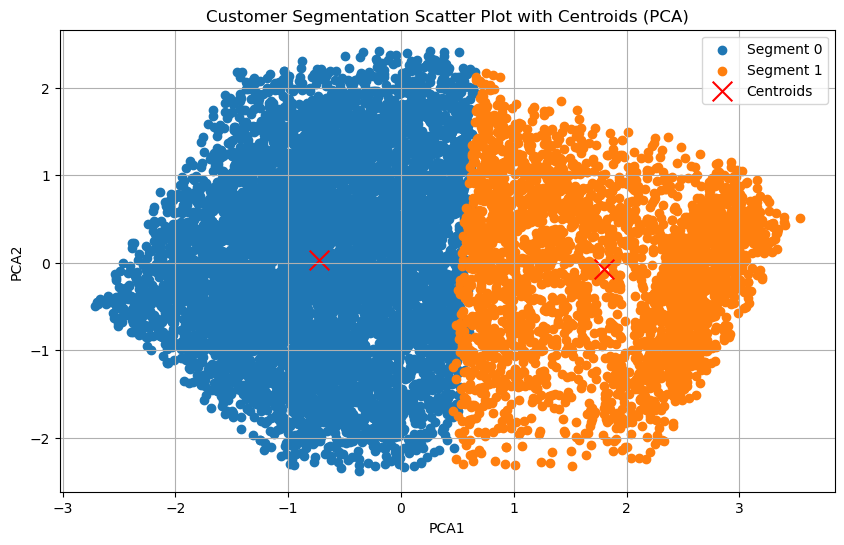

In [127]:
# Melakukan visualisasi dari hasil clustering KMeans menggunakan PCA
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)

plt.figure(figsize=(10, 6))

for segment in data['Segment'].unique():
    plt.scatter(pca_data[data['Segment'] == segment, 0], 
                pca_data[data['Segment'] == segment, 1], 
                label=f"Segment {segment}")

plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
            color='red', marker='x', s=200, label='Centroids')

plt.title('Customer Segmentation Scatter Plot with Centroids (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
# Menampilkan apa saja fitur yang diwakilkan saat mereduksi fitur
pca_components = pd.DataFrame(pca.components_, columns=features, index=[f'PCA{i+1}' for i in range(pca.n_components_)])
print(pca_components)

      Purchase_Frequency  Average_Order_Value  Churn_Probability  \
PCA1            0.354105             0.310340          -0.523621   
PCA2            0.795893             0.085839           0.598465   

      Time_Between_Purchases  Lifetime_Value  
PCA1               -0.020773        0.709710  
PCA2               -0.031458        0.005982  


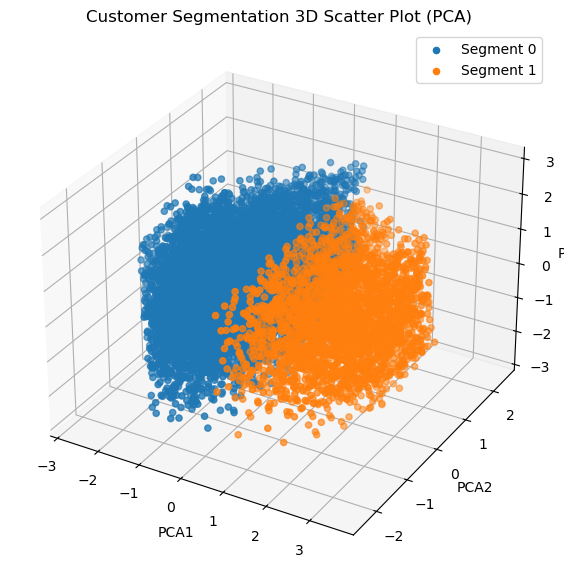

In [132]:
# Reduksi dimensi menjadi 3 komponen utama
pca_3d = PCA(n_components=3)
pca_data_3d = pca_3d.fit_transform(segmented_data)

from mpl_toolkits.mplot3d import Axes3D

# Scatter plot 3D menggunakan PCA
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for segment in data['Segment'].unique():
    ax.scatter(data[data['Segment'] == segment]['PCA1'], 
               data[data['Segment'] == segment]['PCA2'], 
               data[data['Segment'] == segment]['PCA3'],
               label=f"Segment {segment}")

ax.set_title('Customer Segmentation 3D Scatter Plot (PCA)')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.legend()
plt.show()


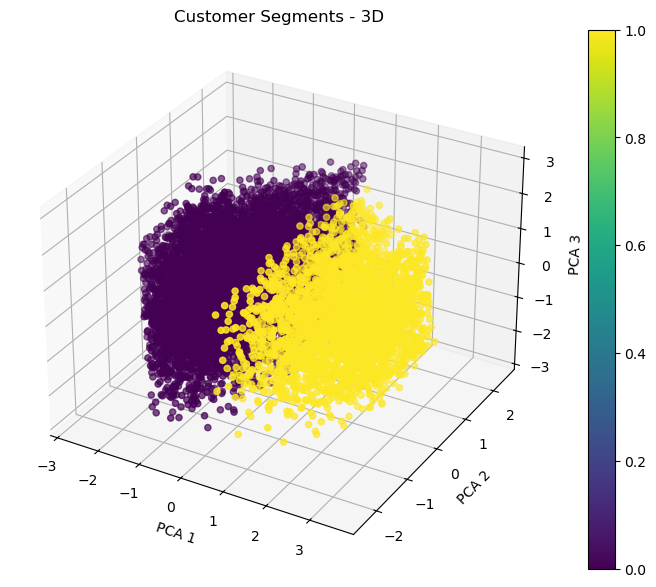

In [123]:
# 3D Scatter Plot
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3 dimensions
pca = PCA(n_components=3)
pca_result = pca.fit_transform(segmented_data)

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=kmeans.labels_, cmap='viridis')
ax.set_title('Customer Segments - 3D')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.colorbar(scatter)
plt.show()

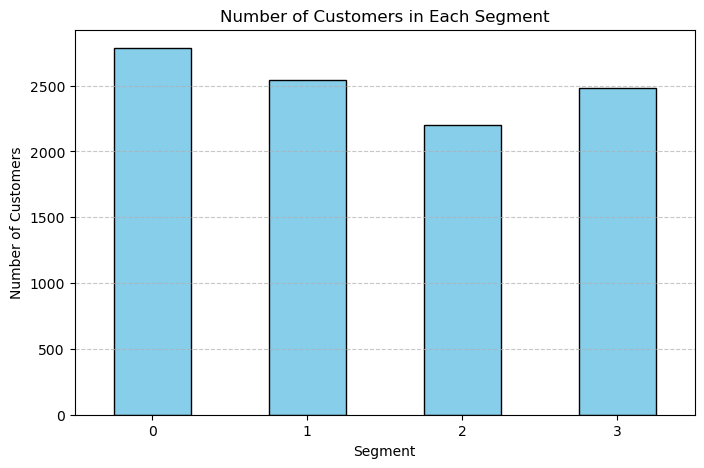

In [31]:
# Melakukan visualisasi data untuk setiap segment dari customer menggunakan Bar Chart
plt.figure(figsize=(8, 5))
data['Segment'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Customers in Each Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()